In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.array([2,2])

array([2, 2])

# Toy Pareto Front
## Setup
Given an vector of installed renewable capacities (in MW), $\bm{X}$, the cost and material needs (of steel) are given by the followinig equations.

$$
c=\bm{C}^{T}\bm{X}
$$
$$
m_{steel}=\bm{M_{steel}}^{T}\bm{X}
$$

where
* $c$ is the total scalar cost,
* $m_{steel}$ is the total scaler material need of steel, 
* $C$ is the cost matrix
* $M_{steel}$ is the material need matrix

For this toy energy system to be feasible, it must satisfy the following feasibility function.

$$
f(\bm{X})=\text{CF}^{T}\bm{X} \ge D
$$
where
* $\text{CF}$ is the vector of capacity factors
* $D$ is the average yearly demand in MW

## Defining vectors
This toy example will consider an energy system comprised of only wind and solar PV generation. Therefore, $\bm{X}$ is defined as
$$
\bm{X}=\begin{pmatrix} x_{wind} \\ x_{solar} \end{pmatrix}
$$
The cost is the economic cost per MW of installed capacity, which is USD 1.50/MW for (onshore) wind and USD 1.66/MW for for solar PV (in the USA in 2022)<sup>1</sup>. Therefore the cost vector is
$$
\bm{C} = \begin{pmatrix} c_{wind} \\ c_{solar} \end{pmatrix} = \begin{pmatrix} 1.50 \\ 1.66 \end{pmatrix}
$$
The material steel requirements are 120-180 tons/MW capacity for wind and 35-45 tons/MW for solar (global in 2022)<sup>2</sup>. Therefore, the material requirements vector is
$$
\bm{M_{steel}} = \begin{pmatrix} m_{steel, wind} \\ m_{steel, solar} \end{pmatrix} = \begin{pmatrix} 150 \\ 40 \end{pmatrix}
$$
The capacity factors are 0.3-0.5 for wind and 0.15-0.2 for solar<sup>3</sup>. Therefore, the capacity factor vector is
$$
\text{CF} = \begin{pmatrix} \text{CF}_{wind} \\ \text{CF}_{solar} \end{pmatrix} = \begin{pmatrix} 0.4 \\ 0.175 \end{pmatrix}
$$
The yearly European electricity consumption is approximately 3000 TWh, which is an average of 350 GW. Therefore, the demand (in MW) is
$$
D = 350,000
$$

In [51]:
c_w = 1.5
c_s = 1.66
m_w = 150
m_s = 40
cf_w = 0.4
cf_s = 0.175
D = 350000

class Sample:
    """
    Class for each wind, solar data point input and their respective output quantities.
    """

    # define constants as class-level attributes
    C = np.array([[c_w], [c_s]])  # cost vector
    M_steel = np.array([[m_w], [m_s]])  # material need vector
    A = np.array([[c_w, c_s], [m_w, m_s]]) # transformation matrix

    CF = np.array([[cf_w], [cf_s]])  # capacity factor vector
    D = D

    def __init__(self, x_wind, x_solar):
        self.x_wind = x_wind
        self.x_solar = x_solar

    @property
    def X(self):
        # Vector representing the two input variables of each sample
        return np.array([[self.x_wind], [self.x_solar]])

    @property
    def is_feasible(self):
        return (Sample.CF.T @ self.X >= Sample.D).item()
    
    @property
    def cost(self):
        return (Sample.C.T @ self.X).item()

    @property
    def material_needs_steel(self):
        return (Sample.M_steel.T @ self.X).item()
    
    @property
    def Y(self):
        # Vector representing the two output variables of each sample (cost, material needs)
        return Sample.A @ self.X


## Sampling from the input space

Using a Monte Carlo technique, $\bm{X}$ can be sampled from a uniform distribution between arbitrary bounds for the capacites of wind and solar. Here we will choose within 50% of the maximum for wind and solar.

By rearranging the feasibility condition, we can find the maximum capacities of wind and solar, which will be used to set the bounds for sampling.
$$
x_{wind}(x_{solar} = 0) = \frac{D}{\text{CF}_{solar}}, \quad
x_{solar}(x_{wind} = 0) = \frac{D}{\text{CF}_{wind}}
$$

In [52]:
num_samples = 5000
samples = []
x_wind_max = Sample.D / Sample.CF[0, 0]
x_solar_max = Sample.D / Sample.CF[1, 0]
x_wind_range = (0, x_wind_max * 1.5)
x_solar_range = (0, x_solar_max * 1.5)

for _ in range(num_samples):
    samples.append(Sample(np.random.uniform(*x_wind_range), np.random.uniform(*x_solar_range)))

## Plotting the input space

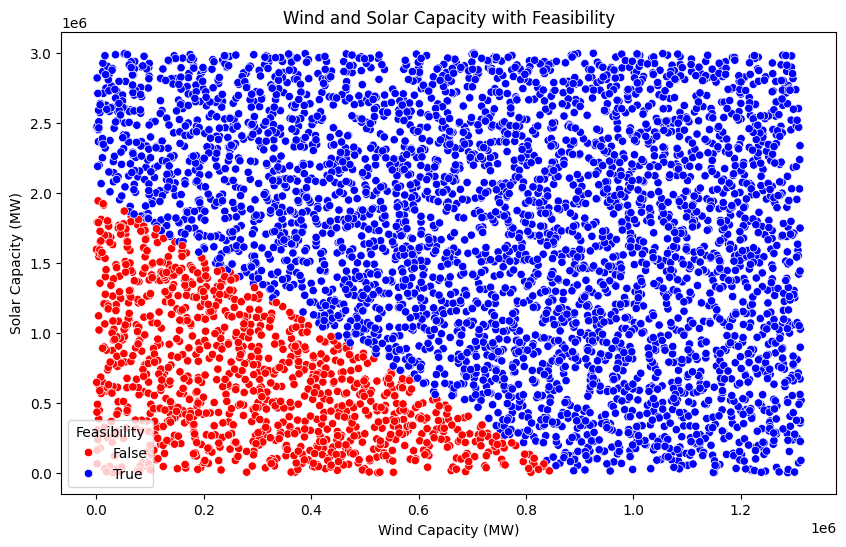

In [53]:
# Convert list of objects into a Pandas DataFrame
x_wind_values = [sample.x_wind for sample in samples]
x_solar_values = [sample.x_solar for sample in samples]

# Calculate the variables for the output space
costs = [sample.cost for sample in samples]
material_needs = [sample.material_needs_steel for sample in samples]
feasibility = [sample.is_feasible for sample in samples]

data = pd.DataFrame({
    'Wind Capacity (MW)': x_wind_values,
    'Solar Capacity (MW)': x_solar_values,
    'Cost (USD)': costs,
    'Material Needs (tons)': material_needs,
    'Feasibility': feasibility,
})

# Plot input space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Wind Capacity (MW)', y='Solar Capacity (MW)', hue='Feasibility', palette=['red', 'blue'])
plt.title('Wind and Solar Capacity with Feasibility')
plt.show()

## Plotting the Pareto Front of materials requirements against cost

We can plot the cost, $c$, and material requirements of steel, $m_{steel}$, for each feasible point in the input space.

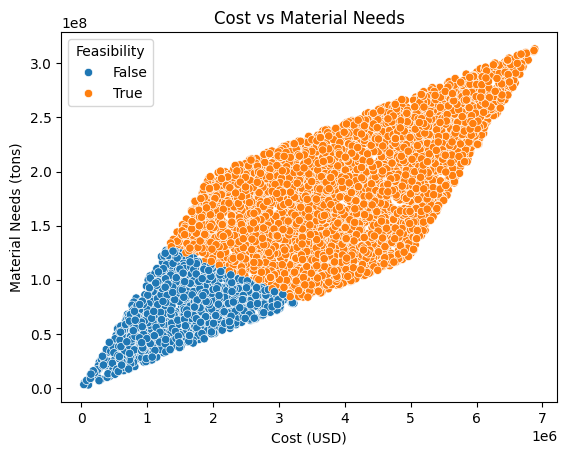

In [54]:
sns.scatterplot(x='Cost (USD)', y='Material Needs (tons)', hue='Feasibility', data=data)
plt.title('Cost vs Material Needs')
plt.show()

## Linear algebra interpretation

$$
c = \bm{C}^{T}\bm{X},\; m = \bm{M}^{T}\bm{X}
\\[10pt]
\bm{Y} = \underbrace{\begin{pmatrix} c_{wind} && c_{solar} \\ m_{steel, wind} && m_{steel, solar} \end{pmatrix}}_{A} \bm{X}
$$

Where $\bm{Y}$ is the output vector, $\bm{Y} =  \begin{pmatrix} c \\ m \end{pmatrix} \in \mathcal{Y}$, where $\mathcal{Y} \subseteq \mathbb{R}^{2} $ is the set of the output space.

This can be visualised as a linear transformation according to matrix $A = \begin{pmatrix} 1.50 && 1.66 \\ 40 && 150 \end{pmatrix}$. This means the input space is linearly mapped to an output space according to the new basis vectors below:

$$
\bm{\hat{i}'} = \begin{bmatrix} 1.5 \\ 40 \end{bmatrix}, \;
\bm{\hat{j}'} = \begin{bmatrix} 1.66 \\ 150 \end{bmatrix}
$$

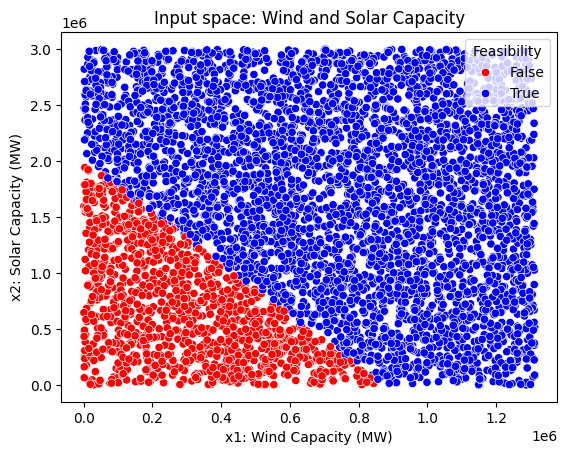

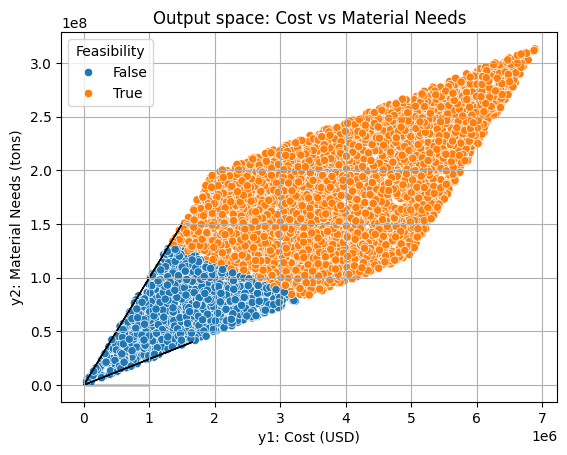

In [55]:
# Transform samples using matrix multiplication (see Sample.Y for implementation)
data_list = []

for sample in samples:
    # Append a new dictionary to the list
    data_list.append(
        {
            "x1: Wind Capacity (MW)": sample.X[0, 0],
            "x2: Solar Capacity (MW)": sample.X[1, 0],
            "y1: Cost (USD)": sample.Y[0, 0],
            "y2: Material Needs (tons)": sample.Y[1, 0],
            "Feasibility": sample.is_feasible,
        }
    )

# Create a DataFrame from the list
data = pd.DataFrame(data_list)
data.set_index(["x1: Wind Capacity (MW)", "x2: Solar Capacity (MW)"], inplace=True)

# calculate the new basis vectors
# basis vectors
i_hat = np.array([[1], [0]])
j_hat = np.array([[0], [1]])

# transformed basis vectors
i_hat_prime = np.array([[c_w], [m_w]])
j_hat_prime = np.array([[c_s], [m_s]])

vectors = [i_hat, j_hat, i_hat_prime, j_hat_prime]

# plot input space
ax1 = sns.scatterplot(data=data, x='x1: Wind Capacity (MW)', y='x2: Solar Capacity (MW)', hue='Feasibility', palette=['red', 'blue'])
plt.title('Input space: Wind and Solar Capacity')
plt.show()

# plot output space with transformed basis vectors
ax2 = sns.scatterplot(x='y1: Cost (USD)', y='y2: Material Needs (tons)', hue='Feasibility', data=data)
plt.title('Output space: Cost vs Material Needs')

# Plot each vector
for v in vectors:
    v = v * 1e6 # scale vectors up so they're visible
    ax2.arrow(0, 0, v[0, 0], v[1, 0])

ax2.grid(True)
plt.show()

Awesome! As we can see, this entire example can be condensed into a single linear transormation (aka. matrix multiplication), according to the matrix $A$. This can be visualised by transforming the 2-D input space of $(x_{wind}, x_{solar})$ into the 2-D output space of $(c, m)$, according to the new basis vectors, $\bm{\hat{i}'}$ and $\bm{\hat{j}'}$.

## Optimising using linear programming

Scipy's linprog function, `scipy.optimize.linprog`, requires LP problems of the following form.

$$
\begin{align}
\text{Find a vector} \quad   &\bm{x} \\
\text{that minimizes} \quad   &\bm{c}^{T}\bm{x} \\
\text{subject to} \quad   &A_{ub}\bm{x}\leq\bm{b_{ub}} \\
\text{and} \quad  \bm{l} \leq &\bm{x} \leq \bm{u} \\
\end{align}
$$

Our system can be minimally described by the following
$$
\bm{y} = A\bm{x} \\[10pt]
\bm{CF}^{T}\bm{x} \ge D
$$
where
$$
\bm{x} = \begin{bmatrix} x_w \\ x_s \end{bmatrix}, \quad
\bm{y} = \begin{bmatrix} c \\ m \end{bmatrix}, \quad
A = \begin{pmatrix} c_w && c_s \\ m_w && m_s \end{pmatrix}, \quad
\bm{CF} = \begin{bmatrix} CF_w \\ CF_s \end{bmatrix}
$$

We have not yet defined an objective function, but we will likely want to minimise some linear combination of the cost, $c$, and material requirement, $m$. We can define this with the vector, $ \bm{c_{y}} $, as follows.
$$
\text{Minimize} \quad \bm{c_{y}}^{T}\bm{y}
$$

Converting our problem into the standard accepted by Scipy results in the following.
$$
\begin{align}
\text{Find a vector} \quad & \bm{x} \\
\text{that minimises} \quad & \underbrace{\bm{c_{y}}^{T}A}_{\bm{c^{T}}}\bm{x} \\
\text{subject to} \quad & \bm{CF}^{T}\bm{x} \ge D \implies \underbrace{-\bm{CF}^{T}}_{A_{ub}} \bm{x} \le \underbrace{-D}_{\bm{b_{ub}}}\\
\text{and} \quad & \underbrace{\bm{0}}_{\bm{l}} \le \bm{x}
\end{align}

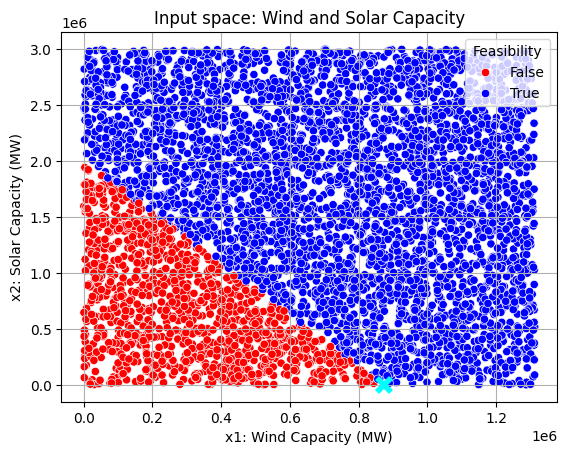

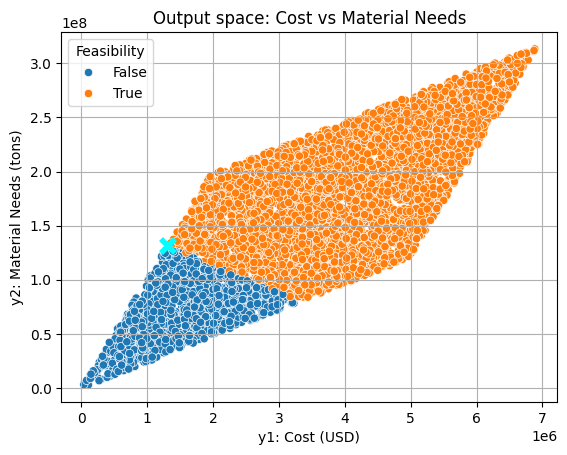

In [61]:
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D

# Define objective function via b
coef_cost = 50
coef_material = 1
c_y = np.array([[coef_cost], [coef_material]])  # Coefficients for cost and material in the objective function
c = c_y.T @ Sample.A

# Define constraints
A_ub = - Sample.CF.T
b_ub = - Sample.D

# Bounds for x
x_bounds = (0, None)

# Solve the linear programming problem
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds)

# Calculate the optimum point using LP
if result.success:
    x_opt = result.x
else:
    print("Optimization failed:", result.message)


# Visualise the optimum point
# plot input space
ax_2d_x = sns.scatterplot(data=data, x='x1: Wind Capacity (MW)', y='x2: Solar Capacity (MW)', hue='Feasibility', palette=['red', 'blue'])
ax_2d_x.plot(x_opt[0], x_opt[1], marker='x', color='cyan', markersize=10, mew=4)
ax_2d_x.grid(True)
plt.title('Input space: Wind and Solar Capacity')
plt.show()

# plot output space
y_opt = Sample.A @ x_opt
ax_2d_y = sns.scatterplot(x='y1: Cost (USD)', y='y2: Material Needs (tons)', hue='Feasibility', data=data)
ax_2d_y.plot(y_opt[0], y_opt[1], marker='x', color='cyan', markersize=10, mew=4)
ax_2d_y.grid(True)
plt.title('Output space: Cost vs Material Needs')
plt.show()

## Show that having more datapoints (as with a SM) leads to richer policy-relevant conclusions

1. look at the material needs of the toy model and compare 2 cost minimal scenarios
1. see how this explains the relationship between autarky and materials
1. then, make a hist of options along the material dimension for both autarky and non-autarky
1. (hopefully) show that having more datapoints results in a much richer understanding of the relationship between x and y
1. then, try and incorporate cost, i.e., limit to w/i 10% of the cost optimum





# References
1. https://www.eia.gov/todayinenergy/detail.php?id=54519 
2. https://cleantechnica.com/2023/03/27/how-much-steel-will-all-those-wind-turbines-solar-panels-need-can-we-make-it/#:~:text=Each%20new%20MW%20of%20solar,to%20180%20tons%20of%20steel
3. https://www.nrel.gov/docs/fy15osti/63038.pdf